In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import re
from datetime import datetime
from PIL import Image
from torchsummary import summary
from matplotlib import pyplot as plt

## Parameter

In [2]:
n_epoch = 20
batch_size = 16
lr = 0.0001
beta1 = 0.5
beta2 = 0.999
lambda_cls = 1
lambda_rec = 10
lambda_gp = 10

In [3]:
cuda = True if torch.cuda.is_available() else False
cuda

True

## Dataset

In [4]:
class Celeb(Dataset):
  def __init__(self, path, name, target, transform = None):
    self.path_dataset = path + '\\' + name
    self.path_attr = path + '\\attr_' + name + '.txt'
    self.target = target
    self.transform = transform
    
    self.images = []
    self.labels = []
    self.label_name = []
    self.target_idx = []
    
    self.attr_label()
    
  def attr_label(self):
    lines = [line.rstrip() for line in open(self.path_attr, 'r')]
    self.label_name = lines[1].split()
    self.target_idx = [self.label_name.index(item) for item in self.target]

    for line in lines[2:]:
      unit = line.split()
      
      self.images.append(unit[0])
      self.labels.append([unit[1:][idx] == '1' for idx in self.target_idx])
    
  def __getitem__(self, idx):
    image = Image.open(self.path_dataset + '\\' + self.images[idx])
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)
    
    return image, torch.FloatTensor(label)
  
  def __len__(self):
    return len(self.labels)

In [5]:
transform = transforms.Compose([
  transforms.CenterCrop((178, 178)), 
  transforms.Resize((128, 128)), 
  transforms.RandomHorizontalFlip(0.5),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
targetA = ['Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']
targetB = ['Wearing_Earrings', 'Wearing_Hat', 'Mustache', 'Eyeglasses']

len_targetA = len(targetA)

In [7]:
datasetA = Celeb('E:\DATASET\celeba', 'celebA', targetA, transform=transform)
datasetB = Celeb('E:\DATASET\celeba', 'celebB', targetB, transform=transform)

In [8]:
print('celebA size : %7d\n celebBsize : %7d' %(len(datasetA), len(datasetB)))

celebA size :   96197
 celebBsize :  106402


In [9]:
dataloaderA = DataLoader(dataset=datasetA, batch_size=batch_size, shuffle=True, drop_last=True)
dataloaderB = DataLoader(dataset=datasetB, batch_size=batch_size, shuffle=True, drop_last=True)

In [10]:
imageA, labelA = next(iter(dataloaderA))
imageB, labelB = next(iter(dataloaderB))

In [11]:
def show_data(image, label, label_name):
  plt.figure(figsize=(8,8))
  plt.suptitle(label_name)

  for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(transforms.functional.to_pil_image(0.5 * image[i] + 0.5))
    plt.title(re.sub(r'[^\d]', '', str(label[i])))
    plt.axis('off')
  
  plt.tight_layout()
  plt.savefig('./history/data.png', dpi=300)
  plt.show()

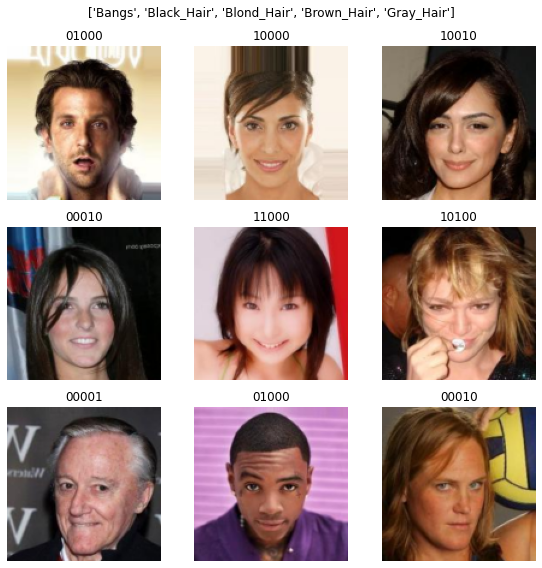

In [12]:
show_data(imageA, labelA, targetA)

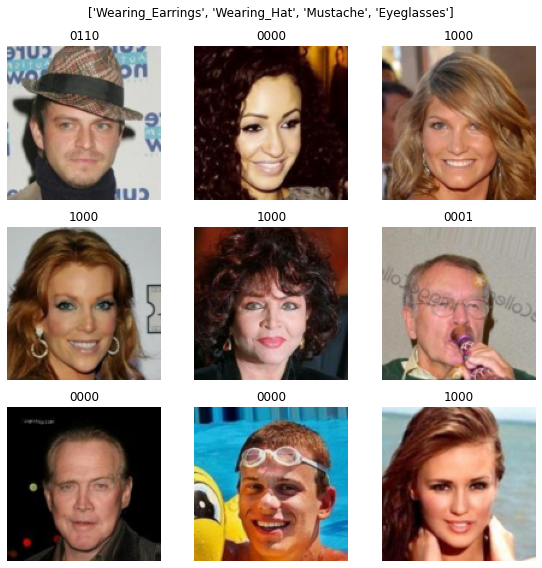

In [13]:
show_data(imageB, labelB, targetB)

## Model

In [14]:
class Residual(nn.Module):
  def __init__(self, in_feature, out_feature):
    super(Residual, self).__init__()
    
    self.model = nn.Sequential(
      nn.Conv2d(in_feature, out_feature, kernel_size=3, padding=1),
      nn.InstanceNorm2d(out_feature),
      nn.ReLU(),
      nn.Conv2d(in_feature, out_feature, kernel_size=3, padding=1),
      nn.InstanceNorm2d(out_feature),
      nn.ReLU()
    )

  def forward(self, x):
    return x + self.model(x)

In [15]:
class Conv(nn.Module):
  def __init__(self, in_feature, out_feature, k, s, p):
    super(Conv, self).__init__()
    
    self.model = nn.Sequential(
      nn.Conv2d(in_feature, out_feature, kernel_size=k, stride=s, padding=p),
      nn.InstanceNorm2d(out_feature),
      nn.ReLU()
    )
    
  def forward(self, x):
    return self.model(x)
  

class Deconv(nn.Module):
  def __init__(self, in_feature, out_feature, k, s, p):
    super(Deconv, self).__init__()
    
    self.model = nn.Sequential(
      nn.ConvTranspose2d(in_feature, out_feature, k, s, p),
      nn.InstanceNorm2d(out_feature),
      nn.ReLU()
    )
  
  def forward(self, x):
    return self.model(x)

In [16]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    
    self.model = nn.Sequential(
      # down-sampling
      Conv(14, 64, 7, 1, 3),
      Conv(64, 128, 4, 2, 1),
      Conv(128, 256, 4, 2, 1),
      
      # 6 residual block(bottleneck)
      Residual(256, 256),
      Residual(256, 256),
      Residual(256, 256),
      Residual(256, 256),
      Residual(256, 256),
      Residual(256, 256),
      
      # up-sampling
      Deconv(256, 128, 4, 2, 1),
      Deconv(128, 64, 4, 2, 1),
      nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
      nn.Tanh()
    )
    
  def forward(self, x, c):
    c = c.view(*c.size(), 1, 1)  # [16, 11, 1, 1]
    c = c.repeat(1, 1, 128, 128)  # [16, 11, 128, 128]
    x = torch.cat((x, c), 1)  # [16, 14(3+11), 128, 128]

    return self.model(x)

In [17]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    
    self.hidden = nn.Sequential(
      # input layer
      nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
      nn.LeakyReLU(0.01),
      
      # hidden layer
      nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
      nn.LeakyReLU(0.01),
      nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
      nn.LeakyReLU(0.01),
      nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
      nn.LeakyReLU(0.01),
      nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
      nn.LeakyReLU(0.01),
      nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1),
      nn.LeakyReLU(0.01)
    )
    
    # output layer
    self.src = nn.Conv2d(2048, 1, kernel_size=3, stride=1, padding=1)
    self.cls = nn.Conv2d(2048, 9, kernel_size=2, stride=1, padding=0)  # 5 : CelebA / 4 : CelebB
    
  def forward(self, x):
    hidden = self.hidden(x)
    x_src = self.src(hidden)
    x_cls = self.cls(hidden)

    return x_src, x_cls

In [18]:
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

Discriminator(
  (hidden): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.01)
  )
  (src): Conv2d(2048, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cls): Conv2d(2048, 9, kernel_size=(2, 2), stride=(1, 1))
)

## Train

In [19]:
history = {'G': [], 'D': [], 'lr': []}

In [20]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

scheduler_lambda = lambda epoch: 1.0 - max(0, epoch - n_epoch//2 - 1) / float(n_epoch)
scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=scheduler_lambda)
scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=scheduler_lambda)

In [21]:
def gradient_penalty(x, y):
  gradients, *_ = torch.autograd.grad(outputs=y, 
                                      inputs=x, 
                                      grad_outputs=y.new_ones(y.shape),
                                      create_graph=True)

  gradients = gradients.view(gradients.size(0), -1)  # norm 계산을 위한 reshape
  norm = gradients.norm(2, dim=-1)  # L2 norm
  return torch.mean((norm -1) ** 2)  # mse (norm - 1)

def generate_label(label):
  fake_label = torch.rand(label.size())
  fake_label = ((0.5 > fake_label).float() * 1).cuda()
  return fake_label

In [22]:
loss_l1 = nn.L1Loss().cuda()
loss_bce = nn.BCEWithLogitsLoss()

zeros = torch.zeros(batch_size, 1).cuda()
ones = torch.ones(batch_size, 1).cuda()

In [23]:
for epoch in range(n_epoch):
  time_start = datetime.now()

  for i in range(2):
    if i == 0:
      dataloader = dataloaderA
    else:
      dataloader = dataloaderB
    
    
    for idx, (images, labels) in enumerate(dataloader):
      images = images.cuda()
      labels = labels.cuda()
      
      '''
      label
      '''
      fake_labels = generate_label(labels)
      
      if i == 0:
        mask = torch.cat([ones, zeros], dim=1)
        label_ignore = torch.zeros(batch_size, 4).cuda()
        condition = torch.cat([labels, label_ignore, mask], dim=1)
        fake_condition = torch.cat([fake_labels, label_ignore, mask], dim=1)
      else:
        mask = torch.cat([zeros, ones], dim=1)
        label_ignore = torch.zeros(batch_size, 5).cuda()
        condition = torch.cat([label_ignore, labels, mask], dim=1)
        fake_condition = torch.cat([label_ignore, fake_labels, mask], dim=1)
      
      '''
      Discriminator
      '''
      optimizer_D.zero_grad()
      
      # classify real
      real_crs, real_cls = discriminator(images)
      real_cls = real_cls[:, :len_targetA] if i%2 ==0 else real_cls[:, len_targetA:]
      
      # classify fake
      fake_images = generator(images, fake_condition)
      fake_crs, _ = discriminator(fake_images)
      
      # gradient penalty
      eps = torch.rand(1).cuda()
      x_hat = (eps * images + (1 - eps) * fake_images)
      crs_hat, _ = discriminator(x_hat)
  
      loss_gp = gradient_penalty(x_hat, crs_hat)
      
      # adv loss
      loss_adv = torch.mean(real_crs) - torch.mean(fake_crs) - lambda_gp * loss_gp
      
      # cls loss
      loss_cls = loss_bce(real_cls.squeeze(), labels)

      # total
      loss_D = -loss_adv + lambda_cls * loss_cls
      history['D'].append(loss_D.item())
      
      # update
      loss_D.backward()
      optimizer_D.step()
      

      '''
      Generator
      '''
      if idx % 5 == 0:
        optimizer_G.zero_grad()

        # generate fake
        fake_images = generator(images, fake_condition)
        fake_crs, fake_cls = discriminator(fake_images)
        fake_cls = fake_cls[:, :len_targetA] if i % 2 == 0 else fake_cls[:, len_targetA:]
        
        # adv loss
        loss_adv = -torch.mean(fake_crs)
        
        # cls loss
        loss_cls = loss_bce(fake_cls.squeeze(), fake_labels)

        # rec loss
        recon_images = generator(fake_images, condition)
        loss_rec = loss_l1(recon_images, images)
        
        # total
        loss_G = loss_adv + lambda_cls * loss_cls + lambda_rec * loss_rec
        history['G'].append(loss_G.item())

        # update
        loss_G.backward()
        optimizer_G.step()
      
      else:
        history['G'].append(history['G'][-1])
      
      '''
      Save history
      '''
      if idx % 1000 == 0:
        print('[idx : %6d] loss_G: %.5f, loss_D: %.5f \n' %(idx, history['G'][-1], history['D'][-1]))
  
  '''
  Scheduler step
  '''
  scheduler_G.step()
  scheduler_D.step()

  '''
  Log
  '''
  time_end = datetime.now() - time_start
  history['lr'].append(optimizer_G.param_groups[0]['lr'])
  
  print('%2dM %2dS / Epoch %2d' %(*divmod(time_end.seconds, 60), epoch+1))
  print('-'*20)
  

[idx :      0] loss_G: 6.84185, loss_D: 10.64337 

[idx :   1000] loss_G: -8.13651, loss_D: -3.64980 

[idx :   2000] loss_G: -6.68233, loss_D: -1.45866 

[idx :   3000] loss_G: 1.19994, loss_D: -2.07109 

[idx :   4000] loss_G: 8.23651, loss_D: -2.79462 

[idx :   5000] loss_G: 3.00642, loss_D: -1.37165 

[idx :   6000] loss_G: -3.55140, loss_D: -2.48533 

[idx :      0] loss_G: 10.24128, loss_D: -1.32884 

[idx :   1000] loss_G: -5.10124, loss_D: -1.51825 

[idx :   2000] loss_G: -1.38463, loss_D: -1.29432 

[idx :   3000] loss_G: -2.55316, loss_D: -1.22572 

[idx :   4000] loss_G: -3.91160, loss_D: -2.37202 

[idx :   5000] loss_G: -1.54151, loss_D: -1.75024 

[idx :   6000] loss_G: -1.97765, loss_D: -2.26832 

82M 18S / Epoch  1
--------------------
[idx :      0] loss_G: -1.35303, loss_D: -0.91922 

[idx :   1000] loss_G: -12.67481, loss_D: -0.91776 

[idx :   2000] loss_G: -0.52074, loss_D: -1.31128 

[idx :   3000] loss_G: 1.76356, loss_D: -2.00017 

[idx :   4000] loss_G: -4.46

## Save

In [24]:
# save
torch.save(generator.state_dict(), './history/generator.pt')
torch.save(discriminator.state_dict(), './history/discriminator.pt')

## History

In [25]:
len(history['D']), len(history['G'])

(253240, 253240)

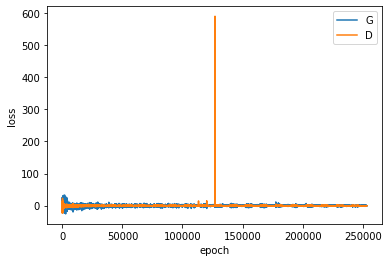

In [26]:
# history loss
plt.plot(range(len(history['G'])), history['G'])
plt.plot(range(len(history['G'])), history['D'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['G', 'D'])

plt.savefig('./history/history_loss.png', dpi=300)
plt.show()

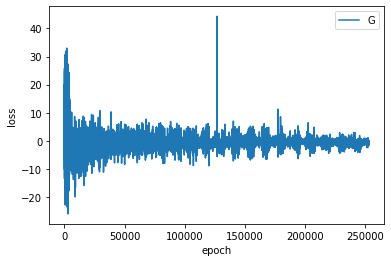

In [27]:
plt.plot(range(len(history['G'])), history['G'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['G'])

plt.savefig('./history/history_loss_G.png', dpi=300)
plt.show()

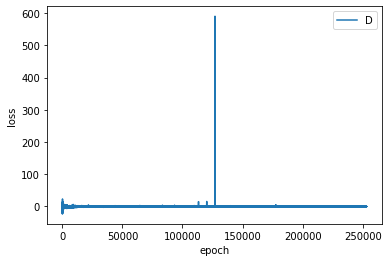

In [28]:
plt.plot(range(len(history['D'])), history['D'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['D'])

plt.savefig('./history/history_loss_D.png', dpi=300)
plt.show()

In [52]:
history2 = [item if item < 30 else 30 for item in history['D']]

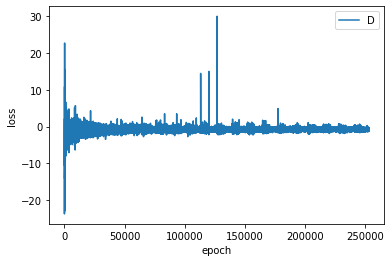

In [54]:
plt.plot(range(len(history['D'])), history2)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['D'])

plt.savefig('./history/history_loss_D2.png', dpi=300)
plt.show()

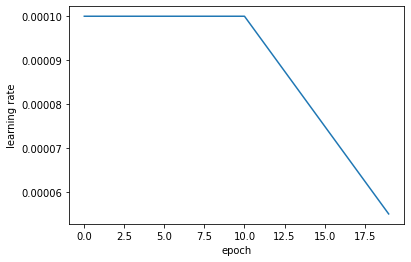

In [29]:
# history lr
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.plot(range(n_epoch), history['lr'])

plt.savefig('./history/history_lr.png', dpi=300)
plt.show()